In [1]:
from BigHF import *


# INPUT
n_x, n_y = [22, 19]
N_elec = 36
r_s = 10
v_q = lambda q: (2 * pi) / q
L_shape = array([sqrt(2 / sqrt(3)), 1 / sqrt(2 / sqrt(3))])
N_pixels = 10000 # For plotting densities.

# Initialize Hartree-Fock system.
L_0 = sqrt(N_elec * pi * r_s ** 2)
L_x, L_y = L_0 * L_shape
system = BigTorus(L_x, L_y, n_x, n_y, ["Electron"], array([N_elec]), 
                  array([[1.0, 1.0]]), [[v_q]])

# Intialize on triangular lattice.
N_lattice = int(sqrt(N_elec))
assert N_elec == N_lattice ** 2
a = L_x / N_lattice * array([[1, 0],
                             [1 / 2, sqrt(3) / 2]])
r_lattice = mgrid[:N_lattice, :N_lattice].reshape(2, N_elec).T @ a
width = 2 * sqrt(r_s)
C_lattice = [lowdin(system.gaussian_orbitals(r_lattice, width))]

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


Setting up Coulomb function ... done!
Setting up exchange function ... done!


2024-10-14 19:40:01.153187: E external/xla/xla/service/slow_operation_alarm.cc:65] Constant folding an instruction is taking > 1s:

  %compare.51 = pred[89,77,45,39]{3,2,1,0} compare(s64[89,77,45,39]{3,2,1,0} %constant.29, s64[89,77,45,39]{3,2,1,0} %broadcast.26), direction=LT, metadata={op_name="jit(coulomb)/jit(main)/lt" source_file="/home/dai/BigTorus/BigHF.py" source_line=293}

This isn't necessarily a bug; constant-folding is inherently a trade-off between compilation time and speed at runtime. XLA has some guards that attempt to keep constant folding from taking too long, but fundamentally you'll always be able to come up with an input program that takes a long time.

If you'd like to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
2024-10-14 19:40:02.927554: E external/xla/xla/service/slow_operation_alarm.cc:133] The operation took 2.77457335s
Constant folding an instruction is taking > 1s:

  %compare.51 = pred[89,77,45,39]{3,2,1,0} compare(

Energy of free Fermi sea: -2.0630022863097652.

Iteration | Fock Calls | Energy               | Delta Energy (Log10) | Time 
____________________________________________________________________________
1         | 4          | -2.2030653677522096  |                      | 82   
2         | 6          | -2.2298376925903334  | -1.5723139141874078  | 86   
3         | 8          | -2.2336597217471477  | -2.417706004200091   | 90   
4         | 10         | -2.2348730147856495  | -2.916034294241129   | 93   
5         | 11         | -2.2350996418587172  | -3.644688210176002   | 95   
6         | 12         | -2.2351417453403624  | -4.375681989752279   | 97   
7         | 13         | -2.235161275439628   | -4.709295549314145   | 99   
8         | 15         | -2.235177220323407   | -4.7973786419571995  | 103  
9         | 16         | -2.2351916379395953  | -4.841106540016839   | 105  
10        | 17         | -2.235197520442212   | -5.230437870975134   | 107  
11        | 18         | -2.

/home/dai/DiskLandauLevelED/ENTER/lib/python3.10/site-packages/scipy/optimize/_optimize.py:1659: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_cg(f, x0, args, fprime, callback=callback, c1=c1, c2=c2,


         Current function value: -2.235207
         Iterations: 44
         Function evaluations: 85
         Gradient evaluations: 73


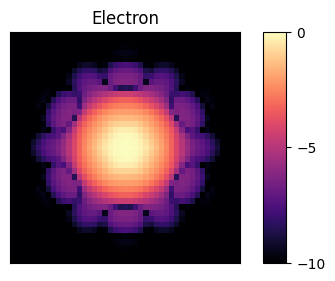

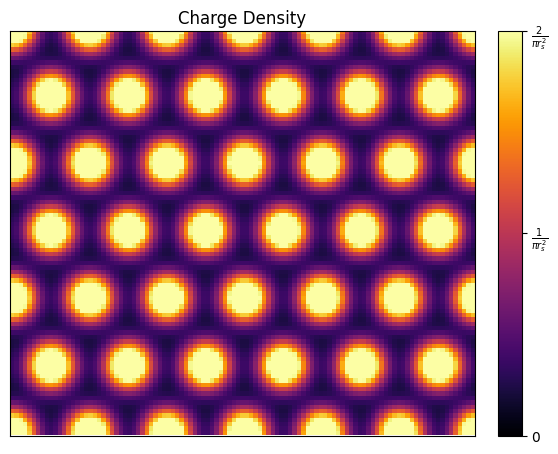

In [2]:
# Minimize energy.
system.coulomb_setup()
system.exchange_setup()
system.run(C_lattice)

# Post-processing.
system.check_basis()
system.visualizer_setup(N_pixels)

# Plot
C_elec = system.C_final[0]
rho_elec = system.calc_rho(C_elec)
fig, ax = plt.subplots(figsize=(6, 6))
ax: plt.Axes = ax
rho_av = 1 / (pi * r_s ** 2)
im = ax.imshow(rho_elec, vmin=0, vmax=2 * rho_av, cmap="inferno",
               origin="lower")
ax.set_title("Charge Density")
ax.set_xticks([], [])
ax.set_yticks([], [])

# Append colorbar to right side.
corners = ax.get_position().get_points()
height = corners[1][1] - corners[0][1]
width = (corners[1][0] - corners[0][0]) / 20
left = corners[1][0] + width
bottom = corners[0][1]
cbar_ax: plt.Axes = fig.add_axes([left, bottom, width, height])
plt.colorbar(im, cax=cbar_ax)
cbar_ax.set_yticks([0, rho_av, 2 * rho_av], [0, r"$\frac{1}{\pi r_s^2}$",
                                             r"$\frac{2}{\pi r_s^2}$"])